
# ViEWS 3 ensembles: future predictions
ViEWS monthly updates, cm level
Fatalities002 version

This notebook produces future predictions for a set of models defined in the list of dictionaries ModelList and the weights stored as iweights_df.csv. Both of these are produced by the notebook fatal_cm_compute_ensemble in this repository. 

The notebook draws on the following .py script files in this repository:

Ensembling.py

FetchData.py

ViewsEstimators.py

It also requires the list of models included in the ensemble, in the following file:

ModelDefinitions.py

In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *
import views_mapper2
from views_mapper2.mapper2 import Mapper2
from views_mapper2 import color
from views_mapper2.label_writer import vid2date
from views_mapper2.dictionary_writer import standard_scale

# Mapper
import geopandas as gpd

import sqlalchemy as sa
#from ingester3.config import source_db_path

# Other packages
import pickle as pkl

#Parallelization
from joblib import Parallel, delayed, cpu_count
from functools import partial

from pathlib import Path

# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
sys.path.append('../SystemUpdates')
import os
from pathlib import Path

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated

from FetchData import FetchData, RetrieveFromList, ReturnQsList, get_df_from_datasets_by_name
from ViewsEstimators import *

In [3]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
RunGeneticAlgo = False
level = 'cm'
WriteToOverleaf = False
get_future = False

username = os.getlogin()

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

#steps = [1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,24] # Which steps to train and predict for
#fi_steps = [1,3,6,12,36] # Which steps to present feature importances for
#steps = [1,12,24,36]
fi_steps = [1,3,6,12,36]
#steps = [1,6,36]
#fi_steps = [1,6,36]

# Specifying partitions

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}
test_partitioner_dict = {"train":(121,444),"predict":(445,492)}
future_partitioner_dict = {"train":(121,492),"predict":(493,504)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

# Specifying paths - note these have to be set to conform to individual setups!

Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
localgitpath = f'/Users/{username}/views3/'
notebookpath = os.getcwd()
markovpath = str(Path(notebookpath).parent.absolute())+'/Tools/markov/'

if WriteToOverleaf:
    if EndOfHistory==508:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    if EndOfHistory==509:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    
    print('Overleaf path set to',overleafpath)

print('Dropbox path set to',Mydropbox)
print('Markov code path set to',markovpath)


Dropbox path set to /Users/jim/Dropbox (ViEWS)/ViEWS/
Markov code path set to /Users/jim/Work/ViEWS/ViEWS3/viewsforecasting/Tools/markov/


# Retrieve models and predictions

In [4]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_baseline_rf baseline002
1 fatalities002_conflicthistory_rf conflict_ln
2 fatalities002_conflicthistory_gbm conflict_ln
3 fatalities002_conflicthistory_hurdle_lgb conflict_ln
4 fatalities002_conflicthistory_long_xgb conflictlong_ln
5 fatalities002_vdem_hurdle_xgb vdem_short
6 fatalities002_wdi_rf wdi_short
7 fatalities002_topics_rf topics_002
8 fatalities002_topics_xgb topics_002
9 fatalities002_topics_hurdle_lgb topics_002
10 fatalities002_joint_broad_rf joint_broad
11 fatalities002_joint_broad_hurdle_rf joint_broad
12 fatalities002_joint_narrow_xgb joint_narrow
13 fatalities002_joint_narrow_hurdle_xgb joint_narrow
14 fatalities002_joint_narrow_hurdle_lgb joint_narrow
15 fatalities002_all_pca3_xgb all_features
16 fatalities002_aquastat_rf aquastat
17 fatalities002_faostat_rf faostat
18 fatalities002_faoprices_rf faoprices
19 fatalities002_imfweo_rf imfweo
20 fat_hh20_Markov_glm joint_narrow
21 fat_hh20_Markov_rf joint_narrow


# Retrieve and calibrate predictions and data

In [39]:
## Running and saving David's models
# Import subprocess to run Rscript
import subprocess

# Fetch and save data (can perhaps be simplified?)
qs = Queryset('hh_20_features','country_month')
qs.fetch().to_parquet(markovpath + 'tmp.parquet')

# Set commands and arguments. R-scripts located in 'Markov'-folder
command ='Rscript'
#path2script ='../Tools/markov/omm_ranger_hh20_fcdo_py.R'
path2script = markovpath + 'omm_ranger_hh20_fcdo_py.R'

cmd = [command, path2script]
data_path = markovpath + 'tmp.parquet'
save_path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'
args = [str(EndOfHistory),data_path,save_path,]

# Run subprocess. Saves the predictions as csv-files to the save_path location with prefix vmm_[estimator]_hh20_[EndOfHistory]
subprocess.call(cmd+args)


 .    
 All required packages installed 

 Packages loaded, starting script 
48.897 sec elapsed
1 
46.399 sec elapsed
2 
47.066 sec elapsed
3 
47.007 sec elapsed
4 
47.325 sec elapsed
5 
48.141 sec elapsed
6 
47.029 sec elapsed
7 
47.543 sec elapsed
8 
47.428 sec elapsed
9 
47.175 sec elapsed
10 
47.543 sec elapsed
11 
47.218 sec elapsed
12 
47.594 sec elapsed
13 
48.165 sec elapsed
14 
48.12 sec elapsed
15 
47.967 sec elapsed
16 
47.799 sec elapsed
17 
47.973 sec elapsed
18 
49.62 sec elapsed
19 
48.956 sec elapsed
20 
47.075 sec elapsed
21 
46.535 sec elapsed
22 
46.441 sec elapsed
23 
46.371 sec elapsed
24 
46.006 sec elapsed
25 
45.761 sec elapsed
26 
45.646 sec elapsed
27 
45.692 sec elapsed
28 
45.169 sec elapsed
29 
44.608 sec elapsed
30 
44.408 sec elapsed
31 
45.291 sec elapsed
32 
45.164 sec elapsed
33 
44.641 sec elapsed
34 
45.225 sec elapsed
35 
44.635 sec elapsed
36 


0

In [5]:
# Retrieve David's models from dropbox and store in prediction storage
path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'

DRList = [
    {
        'modelname': 'fat_hh20_Markov_glm',
        'filename': path + 'vmm_glm_hh20_' + str(EndOfHistory) + '.csv'
    },
    
    {
        'modelname': 'fat_hh20_Markov_rf',
        'filename': path + 'vmm_rf_hh20_' + str(EndOfHistory) + '.csv'
    }
]
    
for model in DRList:
    df_future = pd.read_csv(model['filename'],index_col=['month_id','country_id'])
    df_future['ln_ged_sb_dep'] = np.nan # Empty dependent variable column for consistency/required by prediction storage function
    stored_modelname = level + '_' + model['modelname'] + '_f' + str(EndOfHistory)
    df_future.forecasts.set_run(dev_id)
    df_future.forecasts.to_store(name=stored_modelname, overwrite=True)    

In [6]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, dev_id, level, get_future)

ModelList = CalibratePredictions(ModelList, EndOfHistory, steps)

0 fatalities002_baseline_rf
pr_46_cm_fatalities002_baseline_rf_calib.parquet
pr_46_cm_fatalities002_baseline_rf_test.parquet
1 fatalities002_conflicthistory_rf
pr_46_cm_fatalities002_conflicthistory_rf_calib.parquet
pr_46_cm_fatalities002_conflicthistory_rf_test.parquet
2 fatalities002_conflicthistory_gbm
pr_46_cm_fatalities002_conflicthistory_gbm_calib.parquet
pr_46_cm_fatalities002_conflicthistory_gbm_test.parquet
3 fatalities002_conflicthistory_hurdle_lgb
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_test.parquet
4 fatalities002_conflicthistory_long_xgb
pr_46_cm_fatalities002_conflicthistory_long_xgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_long_xgb_test.parquet
5 fatalities002_vdem_hurdle_xgb
pr_46_cm_fatalities002_vdem_hurdle_xgb_calib.parquet
pr_46_cm_fatalities002_vdem_hurdle_xgb_test.parquet
6 fatalities002_wdi_rf
pr_46_cm_fatalities002_wdi_rf_calib.parquet
pr_46_cm_fatalities002_wdi_rf_test.parquet

Unable to stream download: ("Connection broken: ConnectionResetError(54, 'Connection reset by peer')", ConnectionResetError(54, 'Connection reset by peer'))


pr_46_cm_fatalities002_topics_rf_test.parquet
8 fatalities002_topics_xgb
pr_46_cm_fatalities002_topics_xgb_calib.parquet
pr_46_cm_fatalities002_topics_xgb_test.parquet
9 fatalities002_topics_hurdle_lgb
pr_46_cm_fatalities002_topics_hurdle_lgb_calib.parquet
pr_46_cm_fatalities002_topics_hurdle_lgb_test.parquet
10 fatalities002_joint_broad_rf
pr_46_cm_fatalities002_joint_broad_rf_calib.parquet
pr_46_cm_fatalities002_joint_broad_rf_test.parquet
11 fatalities002_joint_broad_hurdle_rf
pr_46_cm_fatalities002_joint_broad_hurdle_rf_calib.parquet
pr_46_cm_fatalities002_joint_broad_hurdle_rf_test.parquet
12 fatalities002_joint_narrow_xgb
pr_46_cm_fatalities002_joint_narrow_xgb_calib.parquet
pr_46_cm_fatalities002_joint_narrow_xgb_test.parquet
13 fatalities002_joint_narrow_hurdle_xgb
pr_46_cm_fatalities002_joint_narrow_hurdle_xgb_calib.parquet
pr_46_cm_fatalities002_joint_narrow_hurdle_xgb_test.parquet
14 fatalities002_joint_narrow_hurdle_lgb
pr_46_cm_fatalities002_joint_narrow_hurdle_lgb_calib.p

In [7]:
# Run querysets and postprocessing (e.g. PCA) to obtain data for future prediction
qslist = ReturnQsList(level)
from FetchData import fetch_cm_data_from_model_def

Datasets=fetch_cm_data_from_model_def(qslist)

 .    fatalities002_baseline; A dataset with 6 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_topics_stub; A dataset with 62 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_aquastat_stub; A dataset with 11 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_cm_conflict_history_stub; A dataset with 24 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_cm_conflict_history_ext; A dataset with 33 columns, with data between t = 1 and 852. (213 units)
 .    fatalities002_vdem_short_stub; A dataset with 58 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_wdi_short_stub; A dataset with 28 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_joint_narrow; A dataset with 39 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_joint_broad_stub; A dataset with 102 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_faostat_stub;A

In [8]:
# EndOfHistory can be reset here to facilitate rerunning several months without rereading input data
# Remove '#' and reset
#EndOfHistory = 506

In [9]:


from views_runs import Storage, StepshiftedModels
from views_partitioning.data_partitioner import DataPartitioner
from viewser import Queryset, Column
from views_runs import operations
from views_runs.run_result import RunResult

from pygam import LogisticGAM, LinearGAM, s, te

RewritePredictions = False # Set this to True to rewrite predictions even if they exist

def RetrainAndPredict(modelname):
    force_retrain = False
    modelstore = storage.Storage()
    # Predictions for true future
    ct = datetime.now()
    print('Future', ct)
    modelstore = storage.Storage()
    model['RunResult_future']  = RunResult.retrain_or_retrieve(
            retrain            = force_retrain,
            store              = modelstore,
            partitioner        = DataPartitioner({"test":future_partitioner_dict}),
            stepshifted_models = StepshiftedModels(model['algorithm'], steps, model['depvar']),
            dataset            = RetrieveFromList(Datasets,model['data_train']),
            queryset_name      = model['queryset'],
            partition_name     = "test",
            timespan_name      = "train",
            storage_name       = model['modelname'] + '_future',
            author_name        = "HH",
    )       
    predictions_future = model['RunResult_future'].run.future_point_predict(EndOfHistory,model['RunResult_future'].data)
    return predictions_future



i = 0
print('Computing predictions, production run ' + prod_id + ', development run ' + dev_id)
for model in ModelList:

    # Loop that checks whether (1) this a model trained outside the main system, 
    # (2) retrieves the prediction if it exists in prediction storage,
    # (3) if not checks whether the trained model exists, retrains if not, 
    # Then calibrates the predictions and stores them if they have not been stored before for this run.
    # To do: set the data_preprocessing to the function in the model dictionary
    
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    
    if 'Markov' not in model['modelname']: # Only Markov models are currently exceptions
        print(i, model['modelname'])

        ct = datetime.now()
        print('Trying to retrieve non-calibrated predictions', ct)
        if RewritePredictions:
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])
        else:
            try:
                model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
                print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

            except KeyError:
                print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
                model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

        # Calibrating and storing   
        # Storing non-calibrated
        
        model['future_df_noncalibrated'].forecasts.set_run(run_id)
        model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True)   
        print('Calibrating')
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
        for step in steps:
            thismonth = EndOfHistory + step
            
            model['future_df_calibrated'].loc[thismonth,'step_combined'] = pd.DataFrame(model['calibration_gams'][step-1]['calibration_GAM'].predict(model['future_df_noncalibrated'].loc[thismonth])).values
         # Storing calibrated
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   
            
    else: # If one of David's Markov models
        print(i, model['modelname'])
            
        model['predstorename_noncalibrated'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
        print(model['predstorename_noncalibrated'], ', run', run_id, 'is being retrieved from dropbox')
        path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'

        if model['modelname'] == 'fat_hh20_Markov_glm':
            DR_filename = path + 'vmm_glm_hh20_' + str(EndOfHistory) + '.csv'
            model['future_df_calibrated'] = pd.read_csv(DR_filename,index_col=['month_id','country_id'])
        if model['modelname'] == 'fat_hh20_Markov_rf':
            DR_filename = path + 'vmm_rf_hh20_' + str(EndOfHistory) + '.csv'
            model['future_df_calibrated'] = pd.read_csv(DR_filename,index_col=['month_id','country_id'])
            
        model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   


    i = i + 1

print('All done')
        
        

Computing predictions, production run 2022_04_t01, development run Fatalities002
0 fatalities002_baseline_rf
Trying to retrieve non-calibrated predictions 2022-11-07 10:14:12.230372
pr_46_cm_fatalities002_baseline_rf_noncalibrated_f509.parquet
Predictions for  cm_fatalities002_baseline_rf_noncalibrated_f509 , run Fatalities002 exist, retrieving from prediction storage
Calibrating
1 fatalities002_conflicthistory_rf
Trying to retrieve non-calibrated predictions 2022-11-07 10:15:21.377269
pr_46_cm_fatalities002_conflicthistory_rf_noncalibrated_f509.parquet
Predictions for  cm_fatalities002_conflicthistory_rf_noncalibrated_f509 , run Fatalities002 exist, retrieving from prediction storage
Calibrating
2 fatalities002_conflicthistory_gbm
Trying to retrieve non-calibrated predictions 2022-11-07 10:16:30.503432
pr_46_cm_fatalities002_conflicthistory_gbm_noncalibrated_f509.parquet
Predictions for  cm_fatalities002_conflicthistory_gbm_noncalibrated_f509 , run Fatalities002 exist, retrieving from

In [10]:
i=0
for ds in Datasets:
    print(i,ds['Name'])
    i = i + 1

0 aquastat
1 conflictlong_ln
2 imfweo
3 vdem_short
4 baseline002
5 faoprices
6 topics_002
7 joint_narrow
8 wdi_short
9 faostat
10 joint_broad
11 conflict_ln
12 all_features
13 pca_all
14 pca_topics
15 pca_vdem
16 pca_wdi


In [46]:
df = Datasets[7]['df']
df.head()
#df.loc[508]['general_efficiency_t48'].describe()

ln_ged_sb_dep  gleditsch_ward  ln_ged_sb  \
month_id country_id                                             
1        1                     0.0           110.0        0.0   
         2                     0.0           115.0        0.0   
         3                     0.0            52.0        0.0   
         4                     0.0           101.0        0.0   
         5                     0.0           990.0        0.0   

                     reign_tenure_months  wdi_sp_pop_totl  wdi_ag_lnd_frst_k2  \
month_id country_id                                                             
1        1                         165.0         780153.0            186021.5   
         2                          51.0         359531.0            153776.3   
         3                         210.0        1084744.0              2420.6   
         4                          11.0       15182611.0            520260.0   
         5                          47.0         155525.0              1761.3   

                     wdi_nv_agr_totl_kn  wdi_sh_sta_maln_zs  \
month_id country_id                                           
1        1                 1.297711e+11                13.2   
         2                 6.871803e+08                11.1   
         3                 1.010259e+09                 6.2   
         4                 1.418301e+09                 3.9   
         5                 2.577181e+08                 1.7   

                     wdi_sl_tlf_totl_fe_zs  wdi_sm_pop_refg_or  ...  \
month_id country_id                                             ...   
1        1                       31.983197                69.0  ...   
         2                       33.861713              6601.0  ...   
         3                       34.173922                12.0  ...   
         4                       36.237358                 5.0  ...   
         5                       35.400184                 5.0  ...   

                     decay_ged_sb_100  decay_ged_sb_500  \
month_id country_id                                       
1        1                        0.0               0.0   
         2                        0.0               0.0   
         3                        0.0               0.0   
         4                        0.0               0.0   
         5                        0.0               0.0   

                     splag_1_decay_ged_sb_5  ste_theta3_stock  \
month_id country_id                                             
1        1                              0.0          13.95300   
         2                              0.0           0.00000   
         3                              0.0           8.36877   
         4                              0.0           5.66054   
         5                              0.0           0.00000   

                     ste_theta11_stock  ste_theta13_stock  ste_theta14_stock  \
month_id country_id                                                            
1        1                     2.74194          60.976009            0.96870   
         2                     0.00000           0.000000            0.00000   
         3                     8.29672           0.854730            2.32960   
         4                     3.78772           3.090630            3.95208   
         5                     0.00000           0.000000            0.00000   

                     splag_ste_theta2_stock  splag_ste_theta11_stock  \
month_id country_id                                                    
1        1                          1.29592                  6.47591   
         2                          1.20244                  5.43013   
         3                          0.00000                  0.00000   
         4                          2.27568                 12.22174   
         5                          0.00000                  0.00000   

                     splag_ste_theta13_stock  
month_id country_id                           
1        1                 

In [11]:
EnsembleList = [] # Separate list of dictionaries for ensembles!

Ensemble = {
    'modelname':            'genetic_ensemble',
    'algorithm':            [],
    'depvar':               'ln_ged_sb_dep',
    'data_train':           [],
    'Algorithm_text':       '',
    'calibration_gams':     [],
    'future_df_calibrated': [],
}
EnsembleList.append(Ensemble)


In [12]:
# Collecting in one df, one column per model
ConstituentModels_df = pd.DataFrame(ModelList[0]['future_df_calibrated']['step_combined'])
ConstituentModels_df.columns = [ModelList[0]['modelname']]
for model in ModelList[1:]:
    ConstituentModels_df[model['modelname']] = pd.DataFrame(model['future_df_calibrated']['step_combined'])


In [13]:
# Retrieve genetic algorithm results
i_weights_df = pd.read_csv('../Intermediates/GeneticWeights.csv')

# Retrieve ensemble predictions for test partition to create categorical predictions

In [14]:
stored_modelname_test = level + '_' + 'ensemble_genetic' + '_test'

ensemble_test_df = pd.DataFrame.forecasts.read_store(stored_modelname_test, run=run_id)
ensemble_test_df.replace([np.inf, -np.inf], 0, inplace=True)  

ensemble_test_df.head()

pr_46_cm_ensemble_genetic_test.parquet


ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
445      1                     0.0     0.005352     0.006032     0.036104   
         2                     0.0     0.006328     0.005449     0.031227   
         3                     0.0     0.004876     0.004701     0.003081   
         4                     0.0     0.005919     0.006264     0.008694   
         5                     0.0     0.005951     0.004576     0.008105   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
445      1              0.006551     0.008710     0.009211     0.014754   
         2              0.005361     0.007036     0.009166     0.011328   
         3              0.003862     0.004985     0.006483     0.006760   
         4              0.006989     0.011231     0.012538     0.013310   
         5              0.004331     0.006397     0.007042     0.008671   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
445      1              0.014403     0.013317  ...      0.084057   
         2              0.015408     0.013070  ...      0.043899   
         3              0.010068     0.009761  ...      0.035037   
         4              0.020956     0.017720  ...      0.057515   
         5              0.012852     0.009450  ...      0.045273   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
445      1               0.098729      0.146694      0.111655      0.162419   
         2               0.045991      0.057028      0.051526      0.052432   
         3               0.041445      0.040403      0.051587      0.052448   
         4               0.070227      0.076700      0.112692      0.116600   
         5               0.043101      0.061003      0.057133      0.055112   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                                           
445      1               0.119925      0.172456      0.114012      0.152184   
         2               0.045582      0.042155      0.046065      0.061007   
         3               0.045081      0.040427      0.042408      0.053962   
         4               0.114357      0.108172      0.143277      0.124714   
         5               0.046421      0.046830      0.047814      0.059044   

                     step_pred_36  
month_id country_id                
445      1               0.169459  
         2               0.063526  
         3               0.056820  
         4               0.164577  
         5               0.060289  

[5 rows x 37 columns]

In [15]:
# Generate dichotomous version of dependent variable
ensemble_test_df['ged_gte_25'] = ensemble_test_df['ln_ged_sb_dep'].apply(lambda x: 1 if x >= np.log1p(25) else 0)
# Generate multiclass version for uncertainty estimation
def ged_categorical(x):
    if x < np.log1p(0.5):
        return 0
    elif x < np.log1p(10):
        return 1
    elif x < np.log1p(100):
        return 2
    elif x < np.log1p(1000):
        return 3
    else :
        return 4

ensemble_test_df['ged_multi'] = ensemble_test_df['ln_ged_sb_dep'].apply(ged_categorical)

ensemble_test_df.describe()

,ln_ged_sb_dep,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,...,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ged_gte_25,ged_multi
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,...,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000
mean,0.498353,0.570969,0.628956,0.667081,0.688486,0.682289,0.700750,0.694528,0.706906,0.725277,...,0.849666,0.824139,0.849094,0.845087,0.848999,0.842459,0.828961,0.824170,0.075698,0.291121
std,1.368332,1.426773,1.537472,1.589267,1.684517,1.613578,1.707656,1.654649,1.670112,1.710433,...,1.720794,1.641991,1.681639,1.698334,1.693675,1.697292,1.687045,1.687022,0.264529,0.766228
min,0.000000,0.003085,0.003564,0.002908,0.003569,0.004520,0.006077,0.005472,0.008742,0.008907,...,0.016628,0.025840,0.027857,-0.005982,-0.003342,-0.026751,0.025131,0.041491,0.000000,0.000000
25%,0.000000,0.005943,0.006369,0.009038,0.006737,0.008179,0.010357,0.011690,0.015944,0.014538,...,0.060040,0.055988,0.057709,0.051558,0.050617,0.051792,0.063311,0.065100,0.000000,0.000000
50%,0.000000,0.009477,0.016518,0.032781,0.020902,0.023144,0.024222,0.028298,0.036579,0.036093,...,0.096944,0.088281,0.096738,0.107018,0.104938,0.107000,0.101482,0.100419,0.000000,0.000000
75%,0.000000,0.059981,0.149033,0.193458,0.171631,0.188964,0.214271,0.206372,0.244496,0.288866,...,0.466784,0.443616,0.446511,0.445307,0.457550,0.449798,0.417035,0.388627,0.000000,0.000000
max,8.698181,8.832977,12.019380,12.467754,15.340246,12.522342,15.369025,13.829173,16.105506,17.180821,...,10.178789,9.803621,9.538641,9.831323,9.905181,9.663446,10.031043,9.563496,1.000000,4.000000


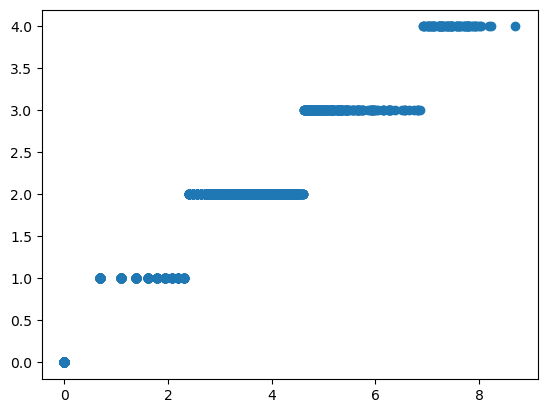

In [16]:
plt.scatter(ensemble_test_df['ln_ged_sb_dep'],ensemble_test_df['ged_multi'])

In [17]:
# Train model to transform predictions from  fatalities to (1) dichotomous and (2) multiclass
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
dichotomous_classifiers = []
multi_classifiers = []
for step in steps:
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Dichotomous
    y_dich = np.array(ensemble_test_df['ged_gte_25']).reshape(-1, 1)
    dich_clf = LogisticRegression(random_state=0).fit(X, y_dich)
    p_dich = dich_clf.predict_proba(X)
    ensemble_test_df[f'dich_step_{step}_logit'] = p_dich[:,1].ravel()
    # Calibrated
    calibrated_dich_clf = CalibratedClassifierCV(base_estimator=dich_clf, cv=3)
    calibrated_dich_clf.fit(X, y_dich)
    p_dich_cal = calibrated_dich_clf.predict_proba(X)
    dichotomous_classifiers.append(calibrated_dich_clf)
    ensemble_test_df[f'dich_cal_step_{step}_logit'] = p_dich_cal[:,1].ravel()
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    p_multi = multi_clf.predict_proba(X)
    for cls in [0,1,2,3,4]:
        ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()

ensemble_test_df[['dich_step_3_logit','dich_cal_step_3_logit']].describe()

,dich_step_3_logit,dich_cal_step_3_logit
count,9168.000000,9168.000000
mean,0.075698,0.075701
std,0.225086,0.223994
min,0.003167,0.003445
25%,0.003197,0.003477
50%,0.003315,0.003603
75%,0.004236,0.004582
max,0.999998,0.999998


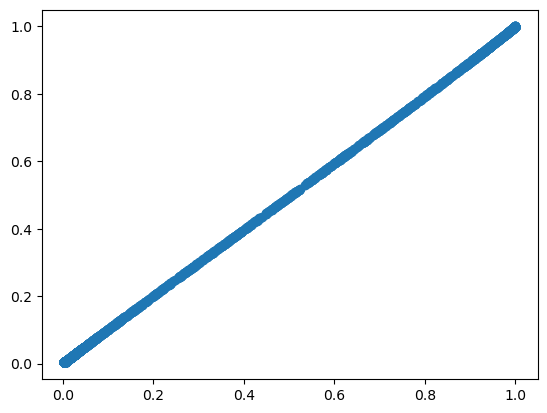

In [18]:
plt.scatter(ensemble_test_df['dich_step_3_logit'],ensemble_test_df['dich_cal_step_3_logit'])

# Calculating and storing ensemble future predictions

In [19]:
# Setting up a placeholder df for ensemble predictions
EnsembleList[0]['future_df_calibrated'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline
EnsembleList[0]['future_df_dichotomous'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline

ConstituentModels_df_w = ConstituentModels_df.copy()

for step in steps:
    month = EndOfHistory + step
    weightcol = 'step_pred_' + str(step)
    weights = np.array(pd.DataFrame(i_weights_df[weightcol]))
    EnsembleList[0]['future_df_calibrated'].loc[month] = ConstituentModels_df_w.loc[month].dot(weights).values
    x_d = np.array(EnsembleList[0]['future_df_calibrated'].loc[month]).reshape(-1,1)
    pred_step = dichotomous_classifiers[step-1].predict_proba(x_d)
    EnsembleList[0]['future_df_dichotomous']['step_combined'].loc[month] = pred_step[:,1]

In [20]:
# Storing the ensemble future predictions
predstore_future = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory)
EnsembleList[0]['future_df_calibrated'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_calibrated'].forecasts.to_store(name=predstore_future, overwrite = True) 
predstore_future_dich = level +  '_' + EnsembleList[0]['modelname'] + '_dich_f' + str(EndOfHistory)
EnsembleList[0]['future_df_dichotomous'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_dichotomous'].forecasts.to_store(name=predstore_future_dich, overwrite = True) 


In [57]:
ViewsMetadata().with_name('genetic').fetch()

,id,name,file_name,runs_id,model_generations_id,user_name,spatial_loa,temporal_loa,ds,osa,time_min,time_max,space_min,space_max,steps,target,prediction_columns,date_written,description,deleted
0,1137,cm_ensemble_genetic_f505,pr_33_cm_ensemble_genetic_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-03-19 08:09:49.362072+00:00,None,False
1,12013,cm_ensemble_genetic_exp_exp_calib,pr_33_cm_ensemble_genetic_exp_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:27.861484+00:00,None,False
2,12014,cm_ensemble_genetic_exp_exp_test,pr_33_cm_ensemble_genetic_exp_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:34.024314+00:00,None,False
3,12017,cm_ensemble_genetic_exp_calib,pr_33_cm_ensemble_genetic_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:40:57.763694+00:00,None,False
4,12018,cm_ensemble_genetic_exp_test,pr_33_cm_ensemble_genetic_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:41:06.365460+00:00,None,False
5,12110,cm_genetic_ensemble_f503,pr_33_cm_genetic_ensemble_f503.parquet,33,1,hh,c,m,False,False,504,539,1,246,[],step_combined,[],2022-04-27 06:28:50.198353+00:00,None,False
6,12141,cm_genetic_ensemble_f505,pr_33_cm_genetic_ensemble_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-04-27 06:50:05.853414+00:00,None,False
7,12173,cm_ensemble_genetic_calib,pr_33_cm_ensemble_genetic_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:18.202727+00:00,None,False
8,12174,cm_ensemble_genetic_test,pr_33_cm_ensemble_genetic_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:26.273595+00:00,None,False
9,12716,cm_genetic_ensemble_f506,pr_33_cm_genetic_ensemble_f506.parquet,33,1,jim,c,m,False,False,507,542,1,246,[],step_combined,[],2022-05-09 16:10:06.894731+00:00,None,False


# Mapping future predictions [cells under this heading will be deleted when present_results.ipynb is ready]

In [21]:
# Prepare the gdf
gdf_base = gpd.read_parquet('../Tools/geometry/cm_geometry.parquet')
gdf = gdf_base.copy()

In [22]:
# Future prediction maps, predictions, rolling
path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/'
stepstoplot=[3,5,8,12,24,36]
#titles = [vid2date(i) for i in stepstoplot + EndOfHistory]


df = EnsembleList[0]['future_df_calibrated'].copy()
gdf2 = gdf_base.copy()
df = df.join(gdf2.set_index("country_id"))
gdf3 = gpd.GeoDataFrame(df, geometry="geom")

In [42]:
gdf3

step_combined  in_africa  in_me  \
month_id country_id                                    
510      1                0.016235          0      0   
         2                0.007206          0      0   
         3                0.031876          0      0   
         4                0.598733          0      0   
         5                0.043157          0      0   
...                            ...        ...    ...   
545      242              1.391367          1      0   
         243              0.849915          1      0   
         244              0.197769          1      0   
         245              1.957203          1      0   
         246              2.587886          1      0   

                                                                  geom  
month_id country_id                                                     
510      1           MULTIPOLYGON (((-58.17262 6.81222, -58.15494 6...  
         2           MULTIPOLYGON (((-55.12796 5.82217, -55.10445 5...  
         3           MULTIPOLYGON (((-61.07945 10.82416, -61.07556 ...  
         4           MULTIPOLYGON (((-66.31029 10.62602, -66.28309 ...  
         5           MULTIPOLYGON (((-172.59650 -13.50911, -172.551...  
...                                                                ...  
545      242         MULTIPOLYGON (((34.13636 -9.57117, 34.07444 -9...  
         243         MULTIPOLYGON (((-4.42042 35.15125, -4.35792 35...  
         244         MULTIPOLYGON (((-10.71639 15.43890, -10.71945 ...  
         245         MULTIPOLYGON (((34.09223 9.47747, 33.90162 9.4...  
         246         MULTIPOLYGON (((34.09223 9.47747, 34.09416 9.4...  

[6876 rows x 4 columns]

In [44]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf,
#        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column='step_combined', 
#        inform_colorbar=True
        )
#        m.cbar.set_ticks(standard_scale)
#        m.cbar.set_ticklabels(standard_scale_labels)
        if WriteToOverleaf:
            m.save(f'{overleafpath}PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')
#        except:
#            print('Overleaf/dropbox folder not found')
        m.save(f'{path}PredictionMap_cm_ensemble_test_standard_scale_r{EndOfHistory}_m{month}.png')

## Retrain the surrogate models

In [45]:
Datasets[1]['df'].loc[544]

,gleditsch_ward,ln_ged_sb_dep,ln_ged_sb,ln_ged_ns,ln_ged_os,ln_acled_sb,ln_acled_sb_count,ln_acled_os,splag_1_ged_sb,splag_2_ged_sb,...,decay_ged_os_500,decay_ged_ns_1,decay_ged_ns_25,decay_ged_ns_500,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,splag_1_decay_ged_sb_100,splag_1_decay_ged_os_100,splag_1_decay_ged_ns_100
country_id,,,,,,,,,,,,,,,,,,,,,
1,110.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,1.545953e-07,1.545953e-07,1.545953e-07,1.545953e-07,0.729041,0.840897,0.709287,4.637860e-07,4.637860e-07,0.363934
2,115.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,1.545953e-07,1.545953e-07,1.545953e-07,1.545953e-07,0.385553,0.423460,0.420448,3.091906e-07,3.091906e-07,0.363913
3,52.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.386294,0.0,0.0,...,1.545953e-07,1.545953e-07,1.545953e-07,1.545953e-07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
4,101.0,0.000000,0.000000,0.000000,1.791759,0.0,0.000000,0.000000,0.0,0.0,...,1.545953e-07,3.242099e-01,7.051713e-05,1.545953e-07,0.806001,0.720762,0.840897,6.569812e-03,4.480651e-04,0.365109
5,990.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,1.545953e-07,1.545953e-07,1.545953e-07,1.545953e-07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,510.0,0.000000,0.000000,0.000000,1.609438,0.0,0.000000,0.000000,0.0,0.0,...,4.073608e-05,5.760952e-05,4.073608e-05,4.073608e-05,2.362406,1.964935,0.842915,7.051099e-01,6.469561e-01,0.423761
243,600.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.693147,0.0,0.0,...,1.545953e-07,1.545953e-07,1.545953e-07,1.545953e-07,0.352258,0.014755,0.018056,3.191396e-03,3.877037e-04,0.000083
244,435.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,1.545953e-07,3.926476e-06,3.926476e-06,1.545953e-07,1.112827,0.830592,0.440007,4.117496e-01,4.208361e-01,0.183542


Dataset with input features: vdem_short
s1 Conflict history
Warning - null values detected:
s1 Democracy libdem_s_1    864
dtype: int64
s1 Democracy
Warning - null values detected:
s1 Rule of law rule_s_1    864
dtype: int64
s1 Rule of law
s1 Population
s1 Infant mortality
s1 Neighborhood conflict
s1 Topics: conflict and conflict stock
s1 Water services efficiency
s2 Conflict history
Warning - null values detected:
s2 Democracy libdem_s_2    864
dtype: int64
s2 Democracy
Warning - null values detected:
s2 Rule of law rule_s_2    864
dtype: int64
s2 Rule of law
s2 Population
s2 Infant mortality
s2 Neighborhood conflict
s2 Topics: conflict and conflict stock
s2 Water services efficiency
s3 Conflict history
Warning - null values detected:
s3 Democracy libdem_s_3    864
dtype: int64
s3 Democracy
Warning - null values detected:
s3 Rule of law rule_s_3    864
dtype: int64
s3 Rule of law
s3 Population
s3 Infant mortality
s3 Neighborhood conflict
s3 Topics: conflict and conflict stock
s3 Water

Warning - null values detected:
s25 Rule of law rule_s_25    864
dtype: int64
s25 Rule of law
s25 Population
s25 Infant mortality
s25 Neighborhood conflict
s25 Topics: conflict and conflict stock
s25 Water services efficiency
s26 Conflict history
Warning - null values detected:
s26 Democracy libdem_s_26    864
dtype: int64
s26 Democracy
Warning - null values detected:
s26 Rule of law rule_s_26    864
dtype: int64
s26 Rule of law
s26 Population
s26 Infant mortality
s26 Neighborhood conflict
s26 Topics: conflict and conflict stock
s26 Water services efficiency
s27 Conflict history
Warning - null values detected:
s27 Democracy libdem_s_27    864
dtype: int64
s27 Democracy
Warning - null values detected:
s27 Rule of law rule_s_27    864
dtype: int64
s27 Rule of law
s27 Population
s27 Infant mortality
s27 Neighborhood conflict
s27 Topics: conflict and conflict stock
s27 Water services efficiency
s28 Conflict history
Warning - null values detected:
s28 Democracy libdem_s_28    864
dtype: int

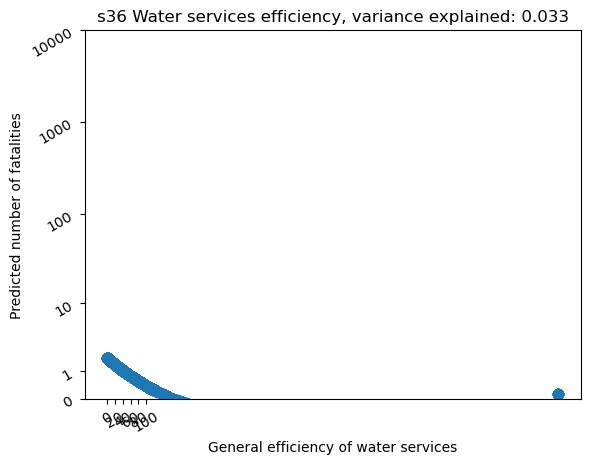

In [52]:
from cm_surrogatemodels import TrainSurrogateModels
SurrogateModelSteps = [1,3,6,36]
SurrogateModelSteps = steps
EndOfHistory_test = test_partitioner_dict['train'][1] 
Plotpath = Mydropbox + 'Projects/PredictingFatalities/SurrogateModels/'

df_all_features = get_df_from_datasets_by_name(Datasets,'all_features')

# Datasets[3] is (currently) the dataframe with all features:
#print('Dataset with input features:', Datasets[3]['Name'])
       
SurrogateModelList = TrainSurrogateModels(data_df = df_all_features, 
                                          Ensemble_df = ensemble_test_df, 
                                          EndOfHistory = EndOfHistory_test, 
                                          SurrogateModelSteps = SurrogateModelSteps, 
                                          NumberOfMonths = 48,
                                          Plotpath = Plotpath)

In [53]:
predictors_df = df_all_features.loc[EndOfHistory]

if predictors_df.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df.isna().sum().sum())
    predictors_df = predictors_df.fillna(0)    


EnsembleList[0]['future_df_surrogates'] = EnsembleList[0]['future_df_calibrated'].copy()
# Initialize dataframe to hold surrogate model predictions:
for item in SurrogateModelList:
    if item['Step'] == 1:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        EnsembleList[0]['future_df_surrogates'][colname] = np.nan  
# Compute predictions for each step
for step in steps:
    month = EndOfHistory + step
#    print('Step',step,'Month',month)
    for item in SurrogateModelList:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        if item['Step']==step:
#            print('colname:',colname,'Step:',item['Step'], item['Columns'])
            EnsembleList[0]['future_df_surrogates'][colname].loc[month] = item['GAM'].predict(predictors_df[item['Columns']])

# Storing the surrogate model future predictions
api_definition = []
for item in SurrogateModelList:
    if item['Step'] == 36:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        predstore_future = level +  '_surrogate_' + item['Shortname'] + '_f' + str(EndOfHistory)
        print('Storing surrogate model predictions for model',colname, 'as:',predstore_future)
        predictions_to_store = pd.DataFrame(EnsembleList[0]['future_df_surrogates'][colname])
        predictions_to_store.forecasts.set_run(run_id)
        predictions_to_store.forecasts.to_store(name=predstore_future, overwrite = True) 
        api_item = {
            'Dev_id': dev_id,
            'EndOfHistory': EndOfHistory,
            'Model': colname,
            'Prediction storage colname': predstore_future
        }
        api_definition.append(api_item)

api_definition

Warning - nulls found in predictors 918
Storing surrogate model predictions for model Conflict history as: cm_surrogate_CH_f509
Storing surrogate model predictions for model Democracy as: cm_surrogate_Dem_f509
Storing surrogate model predictions for model Rule of law as: cm_surrogate_Rule_f509
Storing surrogate model predictions for model Population as: cm_surrogate_Pop_f509
Storing surrogate model predictions for model Infant mortality as: cm_surrogate_IMR_f509
Storing surrogate model predictions for model Neighborhood conflict as: cm_surrogate_NCH_f509
Storing surrogate model predictions for model Topics: conflict and conflict stock as: cm_surrogate_Topic10_f509
Storing surrogate model predictions for model Water services efficiency as: cm_surrogate_Water_f509


[{'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Conflict history',
  'Prediction storage colname': 'cm_surrogate_CH_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Democracy',
  'Prediction storage colname': 'cm_surrogate_Dem_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Rule of law',
  'Prediction storage colname': 'cm_surrogate_Rule_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Population',
  'Prediction storage colname': 'cm_surrogate_Pop_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Infant mortality',
  'Prediction storage colname': 'cm_surrogate_IMR_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Neighborhood conflict',
  'Prediction storage colname': 'cm_surrogate_NCH_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Topics: conflict and conflict stock',
  'Prediction storage colname': 'cm_surrogate_Topic10_f509'},
 {'

In [54]:
import json
with open( '../Intermediates/api_definition.json', 'w') as api_file:
    json.dump(api_definition,api_file)

In [55]:
for model in SurrogateModelList:
    if model['Step'] == 1:
        print(model['Modelname'])

s1 Conflict history
s1 Democracy
s1 Rule of law
s1 Population
s1 Infant mortality
s1 Neighborhood conflict
s1 Topics: conflict and conflict stock
s1 Water services efficiency


In [57]:
# Mapping

#predictors_df = Datasets[10]['df'].loc[EndOfHistory]
#predictors_df_3m = Datasets[10]['df'].loc[EndOfHistory-3]

predictors_df = df_all_features.loc[EndOfHistory]
predictors_df_3m = df_all_features.loc[EndOfHistory-3]

if predictors_df.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df.isna().sum().sum())
    predictors_df = predictors_df.fillna(0)
    
if predictors_df_3m.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df_3m.isna().sum().sum())
    predictors_df_3m = predictors_df_3m.fillna(0)    

path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/Surrogate/'
surrogate_scale=[np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100), np.log1p(300)]

surrogate_scale_labels = ['', '','', '', '', '']

MapSteps = [1,3,6,12,36]
for model in SurrogateModelList:
    if model['Step'] in MapSteps:
        print(model['Modelname'], model['Columns'])

        df = predictors_df[model['Columns']]
        df[model['Predcolname']] = model['GAM'].predict(predictors_df[model['Columns']])
        gdf2 = gdf_base.copy()
        df = df.join(gdf2.set_index("country_id"))
        gdf3 = gpd.GeoDataFrame(df, geometry="geom")
        Predcolname = model['Predcolname']
        step = model['Step']
        TargetMonth = EndOfHistory+step

        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Surrogate model ' + model['Modelname'] + ' predictions as of ' + vid2date(TargetMonth) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf3,
#        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=model['Predcolname'], 
#        inform_colorbar=True
        )
        m.cbar.set_ticks(surrogate_scale)
#        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(f'{path}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')
        if WriteToOverleaf:
            m.save(f'{overleafpath}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')


Warning - nulls found in predictors 918
Warning - nulls found in predictors 918
s1 Conflict history ['ln_ged_sb_dep']
s1 Democracy ['vdem_v2x_libdem']
s1 Rule of law ['vdem_v2x_rule']
s1 Population ['wdi_sp_pop_totl']
s1 Infant mortality ['wdi_sp_dyn_imrt_in']
s1 Neighborhood conflict ['splag_1_decay_ged_sb_5']
s1 Topics: conflict and conflict stock ['topic10_conflict_t1', 'topic10_conflict_t1_stock']
s1 Water services efficiency ['general_efficiency_t48']
s3 Conflict history ['ln_ged_sb_dep']
s3 Democracy ['vdem_v2x_libdem']
s3 Rule of law ['vdem_v2x_rule']
s3 Population ['wdi_sp_pop_totl']
s3 Infant mortality ['wdi_sp_dyn_imrt_in']
s3 Neighborhood conflict ['splag_1_decay_ged_sb_5']
s3 Topics: conflict and conflict stock ['topic10_conflict_t1', 'topic10_conflict_t1_stock']
s3 Water services efficiency ['general_efficiency_t48']
s6 Conflict history ['ln_ged_sb_dep']
s6 Democracy ['vdem_v2x_libdem']
s6 Rule of law ['vdem_v2x_rule']
s6 Population ['wdi_sp_pop_totl']
s6 Infant mortality 

# Changes to 3- and 6-month forecasts, and since last actual observation

In [58]:
# Reading in data for mapping
# Predictions now and then
predstore_then = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory-3)

df_now = EnsembleList[0]['future_df_calibrated'].copy()
try:
    df_then = pd.DataFrame.forecasts.read_store(run=run_id, name=predstore_then)
except:
    print('Trouble reading forecasts issued three months ago')
    
# Actuals
qs = (Queryset("hh_fatalities_ged_ln_ultrashort", "country_month"))
df_lastobserved = qs.fetch().astype(float)

pr_46_cm_genetic_ensemble_f506.parquet
 .    

In [59]:
ViewsMetadata().with_name('ensemble_f506').fetch()

,id,name,file_name,runs_id,model_generations_id,user_name,spatial_loa,temporal_loa,ds,osa,time_min,time_max,space_min,space_max,steps,target,prediction_columns,date_written,description,deleted
0,12489,pgm_cm_calibrated_ensemble_f506,pr_41_pgm_cm_calibrated_ensemble_f506.parquet,41,1,jim,pg,m,False,False,507,542,62356,190511,[],step_combined,[],2022-05-09 10:12:35.185157+00:00,None,False
1,12716,cm_genetic_ensemble_f506,pr_33_cm_genetic_ensemble_f506.parquet,33,1,jim,c,m,False,False,507,542,1,246,[],step_combined,[],2022-05-09 16:10:06.894731+00:00,None,False
2,14717,cm_genetic_ensemble_f506,pr_46_cm_genetic_ensemble_f506.parquet,46,1,hh,c,m,False,False,507,542,1,246,[],step_combined,[],2022-06-26 08:56:01.839228+00:00,None,False
3,14907,cm_genetic_ensemble_f506,pr_45_cm_genetic_ensemble_f506.parquet,45,1,angelica,c,m,False,False,507,542,1,246,[],step_combined,[],2022-06-27 16:41:37.007765+00:00,None,False


In [60]:
# Compute log of mean non-logged fatalities, past six months
df_observed = df_lastobserved.loc[EndOfHistory]
df_observed['ged_sb_0'] = np.expm1(df_observed['ln_ged_sb'])
df_observed['ged_sum'] = df_observed['ged_sb_0']
for t in [1,2,3,4,5]:
    colname = 'ged_sb_' + str(t)
    df_observed[colname] = np.expm1(df_lastobserved.loc[EndOfHistory-t]['ln_ged_sb'])
    df_observed['ged_sum'] = df_observed['ged_sum'] + df_observed[colname]
df_observed['ln_ged_sum'] = np.log1p(df_observed['ged_sum']/6)
#df_observed.tail(20)

In [62]:
StepsForward = [
{
    'Step': 3,
    'df_now': df_now.loc[EndOfHistory + 3],
    'df_then': df_then.loc[EndOfHistory - 3 + 3]
},
{
    'Step': 6,
    'df_now': df_now.loc[EndOfHistory + 6],
    'df_then': df_then.loc[EndOfHistory - 3 + 6]
},
    {
    'Step': 12,
    'df_now': df_now.loc[EndOfHistory + 12],
    'df_then': df_then.loc[EndOfHistory - 3 + 12]
},
    {
    'Step': 36,
    'df_now': df_now.loc[EndOfHistory + 36],
    'df_then': df_then.loc[EndOfHistory - 3 + 36]
},
]
engine = sa.create_engine(source_db_path)
#predictors_df = Datasets[1]['df'].loc[EndOfHistory]
#predictors_df_3m = Datasets[1]['df'].loc[EndOfHistory-3]

predictors_df = df_all_features.loc[EndOfHistory]
predictors_df_3m = df_all_features.loc[EndOfHistory-3]

if predictors_df.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df.isna().sum().sum())
    predictors_df = predictors_df.fillna(0)
    
if predictors_df_3m.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df_3m.isna().sum().sum())
    predictors_df_3m = predictors_df_3m.fillna(0)    
    

for s in StepsForward:
    s['df_now'].rename(columns={'step_combined':'Now'}, inplace=True)
    s['df_then'].rename(columns={'step_combined':'Then'}, inplace=True)
    s['df'] = pd.concat([s['df_now'],s['df_then'],df_observed['ln_ged_sum']],axis=1)
    s['df']['Change_in_prediction'] = s['df']['Now']-s['df']['Then']
    s['df']['Change_since_last_observed'] = s['df']['Now']-s['df']['ln_ged_sum']
    
    # Surrogate model change
    for sm in SurrogateModelList:
#        print(sm)
        if sm['Step'] == s['Step']:
            s['sdf'] = predictors_df[sm['Columns']]
            s['sdf'][sm['Predcolname']] = sm['GAM'].predict(predictors_df[sm['Columns']])
            s['sdf_3m'] = predictors_df_3m[sm['Columns']]
            s['sdf_3m'][sm['Predcolname']] = sm['GAM'].predict(predictors_df_3m[sm['Columns']])
            print(sm['Step'],sm['Predcolname'])
            dfcolname = 's_pred_m' + sm['Shortname'] + '_ch3m' 
            s['df'][dfcolname] = s['sdf'][sm['Predcolname']] - s['sdf_3m'][sm['Predcolname']]
    
    s['gdf'] = gpd.GeoDataFrame.from_postgis(
        "SELECT id as country_id, in_africa, in_me, geom FROM prod.country", 
        engine, 
        geom_col='geom'
    )
    s['gdf'] = s['gdf'].to_crs(4326)

    s['gdf_t'] = s['df'].join(s['gdf'].set_index("country_id"))
    s['gdf'] = gpd.GeoDataFrame(s['gdf_t'], geometry="geom")
    
    

Warning - nulls found in predictors 918
Warning - nulls found in predictors 918
3 s_pred_mCH_3
3 s_pred_mDem_3
3 s_pred_mRule_3
3 s_pred_mPop_3
3 s_pred_mIMR_3
3 s_pred_mNCH_3
3 s_pred_mTopic10_3
3 s_pred_mWater_3
6 s_pred_mCH_6
6 s_pred_mDem_6
6 s_pred_mRule_6
6 s_pred_mPop_6
6 s_pred_mIMR_6
6 s_pred_mNCH_6
6 s_pred_mTopic10_6
6 s_pred_mWater_6
12 s_pred_mCH_12
12 s_pred_mDem_12
12 s_pred_mRule_12
12 s_pred_mPop_12
12 s_pred_mIMR_12
12 s_pred_mNCH_12
12 s_pred_mTopic10_12
12 s_pred_mWater_12
36 s_pred_mCH_36
36 s_pred_mDem_36
36 s_pred_mRule_36
36 s_pred_mPop_36
36 s_pred_mIMR_36
36 s_pred_mNCH_36
36 s_pred_mTopic10_36
36 s_pred_mWater_36


In [64]:
predictors_df

,renewable_pcap_t48,decay_ged_sb_5,decay_ged_os_5,decay_ged_sb_100,decay_ged_sb_500,decay_ged_os_100,decay_ged_ns_5,decay_ged_ns_100,decay_acled_sb_5,decay_acled_os_5,...,agr_withdrawal_pct_t48,dam_cap_pcap_t48,groundwater_export_t48,fresh_withdrawal_pct_t48,ind_efficiency_t48,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48
country_id,,,,,,,,,,,,,,,,,,,,,
1,347879.220442,4.248136e-07,8.277055e-03,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,...,0.502952,1038.695466,0.00,0.533100,58.553101,0.004722,27.403603,1.994019,3.298402,309368.605633
2,171877.983993,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,...,0.435455,34722.825049,0.00,0.622121,10.361299,1.145940,50.362008,7.112872,3.950609,171877.983993
3,2762.901997,1.712741e-05,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,1.000000e+00,...,0.434896,51.423074,0.00,8.755208,68.894048,2.486702,56.613540,58.385564,20.326481,2762.901997
4,45868.196336,9.438743e-01,9.715319e-01,4.248136e-07,4.248136e-07,4.248136e-07,7.937005e-01,5.596949e-05,7.071068e-01,9.438743e-01,...,1.261132,5456.608721,0.00,1.707253,81.582445,0.252455,21.017021,7.805434,7.540367,27867.092868
5,0.000000,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,...,0.000000,50.986850,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,1709.538672,8.908987e-01,6.120268e-01,1.119390e-04,1.119390e-04,1.119390e-04,1.583056e-04,1.119390e-04,8.908987e-01,8.655366e-01,...,4.811468,1850.334551,0.00,5.384855,614.734859,0.192982,43.054457,7.513882,12.963241,1491.651069
243,804.905080,9.170040e-01,1.421536e-03,1.320704e-05,4.248136e-07,4.248136e-07,4.248136e-07,4.248136e-07,8.908987e-01,8.655366e-01,...,31.572414,498.444132,0.03,36.458621,126.389217,0.432900,56.591798,8.715869,50.751212,804.905080
244,2588.959722,2.409704e-02,1.922487e-05,4.248136e-07,4.248136e-07,4.248136e-07,1.078959e-05,1.078959e-05,2.409704e-02,1.463191e-03,...,10.728070,113.550865,0.00,11.826316,47.668220,0.352241,35.254024,3.932657,13.246217,90.840692


In [65]:
StepsForward[3]['gdf'].describe()

,Now,Then,ln_ged_sum,Change_in_prediction,Change_since_last_observed,s_pred_mCH_ch3m,s_pred_mDem_ch3m,s_pred_mRule_ch3m,s_pred_mPop_ch3m,s_pred_mIMR_ch3m,s_pred_mNCH_ch3m,s_pred_mTopic10_ch3m,s_pred_mWater_ch3m,in_africa,in_me
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.0,191.0,191.0,191.0,191.000000,191.000000,191.0,191.000000,191.000000
mean,0.860146,0.823155,0.663213,0.036991,0.196932,0.001241,0.0,0.0,0.0,0.0,0.036434,0.065667,0.0,0.282723,0.068063
std,1.480939,1.420895,1.483915,0.297873,0.567906,0.859228,0.0,0.0,0.0,0.0,0.201473,0.324935,0.0,0.451506,0.252516
min,0.062814,0.056496,0.000000,-1.307490,-4.391336,-3.166740,0.0,0.0,0.0,0.0,-0.261033,-0.984767,0.0,0.000000,0.000000
25%,0.114618,0.082470,0.000000,-0.014661,0.096938,0.000000,0.0,0.0,0.0,0.0,-0.012671,-0.049864,0.0,0.000000,0.000000
50%,0.174795,0.161826,0.000000,0.024541,0.130420,0.000000,0.0,0.0,0.0,0.0,0.000000,0.011820,0.0,0.000000,0.000000
75%,0.596406,0.629634,0.405465,0.042675,0.262897,0.000000,0.0,0.0,0.0,0.0,0.001070,0.183366,0.0,1.000000,0.000000
max,6.720378,7.129338,8.334472,1.667800,2.443946,4.439581,0.0,0.0,0.0,0.0,1.177277,1.807401,0.0,1.000000,1.000000


In [66]:
SurrogateModelList

[{'Modelname': 's1 Conflict history',
  'Shortname': 'CH',
  'Longdescription': 'long description in here',
  'Step': 1,
  'Columns': ['ln_ged_sb_dep'],
  'IVs':                      depvar_s_1
  month_id country_id            
  445      1             0.000000
           2             0.000000
           3             0.000000
           4             0.000000
           5             0.000000
  ...                         ...
  492      242           0.000000
           243           0.000000
           244           0.000000
           245           0.000000
           246           2.484907
  
  [9168 rows x 1 columns],
  'Prediction': month_id  country_id
  445       1             0.005352
            2             0.006328
            3             0.004876
            4             0.005919
            5             0.005951
                            ...   
  492       242           0.967565
            243           0.009336
            244           0.018471
            245 

In [67]:
delta = 3

tickvalues=np.array([-300,-30,-3,3,30,300])
ticklabels=[str(tv) for tv in tickvalues]

tickvalues=np.sign(tickvalues)*np.log1p(np.abs(tickvalues)+1)
#print(tickvalues)
tickvalues = np.array([-83,-80,-50,-20,0,20,50,100,200,500])
ticklabels=[str(tv) for tv in tickvalues]
ticklabels[0] = ""
tickvalues = np.log((100+tickvalues)/100)


t0s=range(506,508) # From start of month A, to start of (but not including) month B
bbox="africa_middle_east"
cmap='bwr'#'rainbow'
ColumnsToPlot = ['Change_in_prediction',
                 'Change_since_last_observed',
                 's_pred_mCH_ch3m',
                 's_pred_mNCH_ch3m',
                 's_pred_mDem_ch3m',
                 's_pred_mIMR_ch3m',
                # 's_pred_mTopics10_ch3m',
                ]


for s in StepsForward:
    print('Step:',s['Step'])
    for column in ColumnsToPlot:
        
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title=f"{column}, s= {s['Step']}",
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=s['gdf'],
#        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=column, 
#        inform_colorbar=True
        )
#        m.cbar.set_ticks(surrogate_scale)
#        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(path+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
#        if WriteToOverleaf:
#            plot.save(overleafpath+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
        

Step: 3
Step: 6
Step: 12
Step: 36


In [68]:
s['gdf'].head()

,Now,Then,ln_ged_sum,Change_in_prediction,Change_since_last_observed,s_pred_mCH_ch3m,s_pred_mDem_ch3m,s_pred_mRule_ch3m,s_pred_mPop_ch3m,s_pred_mIMR_ch3m,s_pred_mNCH_ch3m,s_pred_mTopic10_ch3m,s_pred_mWater_ch3m,in_africa,in_me,geom
country_id,,,,,,,,,,,,,,,,
1,0.198702,0.091337,0.000000,0.107365,0.198702,0.000000,0.0,0.0,0.0,0.0,1.024345,0.015364,0.0,0,0,"MULTIPOLYGON (((-58.17262 6.81222, -58.15494 6..."
2,0.107415,0.082236,0.000000,0.025179,0.107415,0.000000,0.0,0.0,0.0,0.0,0.234566,0.000000,0.0,0,0,"MULTIPOLYGON (((-55.12796 5.82217, -55.10445 5..."
3,0.086755,0.073748,0.000000,0.013008,0.086755,0.000000,0.0,0.0,0.0,0.0,0.000000,0.224312,0.0,0,0,"MULTIPOLYGON (((-61.07945 10.82416, -61.07556 ..."
4,0.881831,1.397723,0.606136,-0.515892,0.275695,-2.430817,0.0,0.0,0.0,0.0,1.022768,-0.055272,0.0,0,0,"MULTIPOLYGON (((-66.31029 10.62602, -66.28309 ..."
5,0.118751,0.077999,0.000000,0.040752,0.118751,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0,0,"MULTIPOLYGON (((-172.59650 -13.50911, -172.551..."


# Uncertainty of predictions

In [69]:
# Train model to transform predictions from  fatalities to multiclass probabilities
from sklearn.linear_model import LogisticRegression
# Classes are: 
# 0: Less than 0.5
# 1: 0.5-10
# 2: 10-100
# 3: 100-1000
# 4: 1000 +

multi_classifiers = []
df_future = EnsembleList[0]['future_df_calibrated'].copy()
for cls in [0,1,2,3,4]:
    df_future[f'multi_{cls}_logit'] = np.nan

for step in steps:
    Month = EndOfHistory + step
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    X_future = np.array(df_future['step_combined'].loc[Month]).reshape(-1,1)
    p_multi = multi_clf.predict_proba(X_future)
    for cls in [0,1,2,3,4]:
        df_future[f'multi_{cls}_logit'].loc[Month] = p_multi[:,cls]

# Storing the multi predictions in prediction storage:
for cls in [0,1,2,3,4]:
    predstore_future_multi = level +  '_multi_' + str(cls) + '_f' + str(EndOfHistory)
    print('Storing multiclass model predictions as:',predstore_future_multi)
    colname = 'multi_' + str(cls) + '_logit'
    predictions_to_store = pd.DataFrame(df_future[colname])
    predictions_to_store.forecasts.set_run(run_id)
    predictions_to_store.forecasts.to_store(name=predstore_future_multi, overwrite = True) 


df_future.describe()

Storing multiclass model predictions as: cm_multi_0_f509
Storing multiclass model predictions as: cm_multi_1_f509
Storing multiclass model predictions as: cm_multi_2_f509
Storing multiclass model predictions as: cm_multi_3_f509
Storing multiclass model predictions as: cm_multi_4_f509


feature,step_combined,multi_0_logit,multi_1_logit,multi_2_logit,multi_3_logit,multi_4_logit
count,6876.000000,6.876000e+03,6876.000000,6876.000000,6876.000000,6.876000e+03
mean,0.787269,8.463307e-01,0.048742,0.080791,0.022659,1.478322e-03
std,1.489454,3.009712e-01,0.068437,0.186395,0.074311,1.353808e-02
min,-0.007853,7.171603e-13,0.000015,0.001783,0.000002,2.615443e-12
25%,0.057293,9.503247e-01,0.016180,0.004730,0.000051,4.391687e-09
50%,0.123328,9.759622e-01,0.018237,0.005804,0.000080,9.858988e-09
75%,0.569019,9.790879e-01,0.033660,0.013997,0.000246,5.575590e-08
max,7.904283,9.834779e-01,0.434963,0.762065,0.642638,7.880657e-01


In [70]:
df_future.head()

feature              step_combined  multi_0_logit  multi_1_logit  \
month_id country_id                                                
510      1                0.016235       0.982667       0.015455   
         2                0.007206       0.983089       0.015094   
         3                0.031876       0.981910       0.016101   
         4                0.598733       0.916612       0.068132   
         5                0.043157       0.981344       0.016583   

feature              multi_2_logit  multi_3_logit  multi_4_logit  
month_id country_id                                               
510      1                0.001876       0.000002   2.875516e-12  
         2                0.001815       0.000002   2.703455e-12  
         3                0.001986       0.000002   3.199839e-12  
         4                0.015219       0.000038   1.477001e-10  
         5                0.002070       0.000003   3.456149e-12

In [71]:
# Some uncertainty calculations
#October 2022 (514)
CL = [
    ('Ethiopia',57,4.114,0.0025217435284640467,0.167910951747582,0.7099704830039664,0.11880956751085855,0.0007872542091291349),
    ('Kenya',237,2.202,0.27979924123523675,0.37093623451842744,0.3384779788333302,0.010780625441912769,5.919971092604168e-06),
    ('Nigeria',79,5.891,1.1834522019553202e-05,0.030050677139008334,0.5285925149395453,0.41358824669460437,0.027756726704822352),
    ('South Africa',163,0.103,0.9794051664145842,0.017598332401191557,0.0029811455728619585,1.5355064175926178e-05,5.471865662986281e-10),
    ('South Sudan',246,1.782,0.5171316993204126,0.2898656997683062,0.18882479925510778,0.004176475005701126,1.3266504722650525e-06),
    ('Sudan',245,1.971,0.40522067161826564,0.3345539054572092,0.2536133366482648,0.006609400618818177,2.6856574423520527e-06),
    ('Syria',220,4.818,0.0003291633453796389,0.09280289507829718,0.6904155754185439,0.21292026113053514,0.0035321050272440497),
    ('Tanzania',242,0.741,0.9214126374988004,0.06115410932346314,0.017278449601019125,0.0001547909157059216,1.2661011272757968e-08),
    ('Yemen',124,6.352,2.556591139139699e-06,0.016708050733656395,0.42553124292260786,0.4969226339388311,0.06083551581376548),
    ('Zimbabwe',158,0.050,0.9816070866339232,0.015813575350686226,0.0025667146500692674,1.2622945665883365e-05,4.196556261097782e-10),
]

for C in CL: 
    print(C[0],C[2],np.expm1(C[2]))
    print('< 0.5:',C[3])
    print('0.5-10:',C[4])
    print('10-100:',C[5])
    print('100-1000:',C[6])
    print('1000+:',C[7])
    print('****')
    

Ethiopia 4.114 60.19099266439019
< 0.5: 0.0025217435284640467
0.5-10: 0.167910951747582
10-100: 0.7099704830039664
100-1000: 0.11880956751085855
1000+: 0.0007872542091291349
****
Kenya 2.202 8.043081588499359
< 0.5: 0.27979924123523675
0.5-10: 0.37093623451842744
10-100: 0.3384779788333302
100-1000: 0.010780625441912769
1000+: 5.919971092604168e-06
****
Nigeria 5.891 360.7668704195498
< 0.5: 1.1834522019553202e-05
0.5-10: 0.030050677139008334
10-100: 0.5285925149395453
100-1000: 0.41358824669460437
1000+: 0.027756726704822352
****
South Africa 0.103 0.10849140907600723
< 0.5: 0.9794051664145842
0.5-10: 0.017598332401191557
10-100: 0.0029811455728619585
100-1000: 1.5355064175926178e-05
1000+: 5.471865662986281e-10
****
South Sudan 1.782 4.941727999051595
< 0.5: 0.5171316993204126
0.5-10: 0.2898656997683062
10-100: 0.18882479925510778
100-1000: 0.004176475005701126
1000+: 1.3266504722650525e-06
****
Sudan 1.971 6.1778507513686165
< 0.5: 0.40522067161826564
0.5-10: 0.3345539054572092
10-1

In [72]:
df_future.to_csv('Categorical_probabilities.csv')